# Effects of Iterations on Reconstruction Algorithms

In [2]:
import cv2
import time
import tomopy 
import matplotlib.pyplot as plt
import numpy as np
import dxchange as dx
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from array import *
rec = dict()

Below is the image that will showcase the differing effects of various algorithms on image reconstruction.

(1, 128, 128)


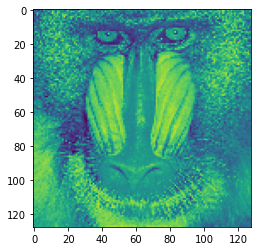

In [21]:
obj = tomopy.baboon(size=128)
print(obj.shape)
plt.figure()
plt.imshow(obj[0])
plt.show()

For this particular image, we are choosing to use 128 angled scans, ranging from 0 degrees to 180.

In [4]:
ang = tomopy.angles(nang=128, ang1=0, ang2=180)


In [5]:
prj = tomopy.project(obj, ang, pad=True)

Below is the simulated sinogram, which will be used to reconstruct the original image.

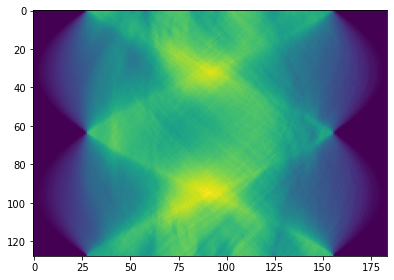

In [6]:
plt.figure(tight_layout=True)
plt.imshow(prj[:, 0, :])
plt.show()

Here we add poisson noise defects to the image in order to simulate experimental imperfections. 

In [7]:
prj_poisson = tomopy.add_poisson(prj/10)*100



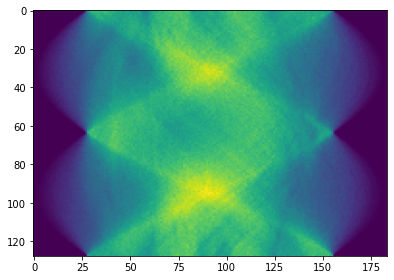

In [8]:
plt.figure(tight_layout=True)
plt.imshow(prj_poisson[:, 0, :])
plt.show()

Once again, we add rings to the sinogram to simulate defects. 

In [9]:
def add_rings(tomo, std=0.005):
    new_tomo = np.copy(tomo)
    sensitivity = np.random.normal(loc=1, scale=std, size=(1, new_tomo.shape[1], new_tomo.shape[2]))
    new_tomo = new_tomo * sensitivity
    return new_tomo


In [10]:
prj_screwed_up = add_rings(prj_poisson)

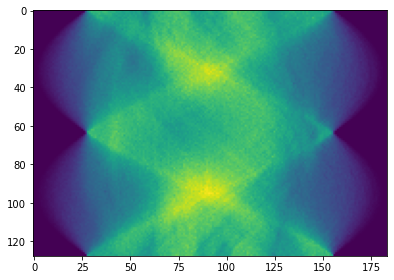

In [15]:
plt.figure(tight_layout=True)
plt.imshow(prj_screwed_up[:, 0, :])
plt.show()

Here we create a dictonary which contains two arrays, both of which contain itteration dependent data values. Array_n contains image reconstructions via the use of one the reconstruction algorithms. Array_t contains the time it takes to run each of these algorithms at various iteration legnths.

In [37]:
def dis (algorithm, y, z):
    arrays = dict();
    array_n = []
    array_t = []
    if algorithm != 'ospml_hybrid2':
        for x in range(1,y+1,z):
            tic = time.perf_counter()
            array_n.append(tomopy.recon(prj_screwed_up, ang, num_gridx=128, algorithm = algorithm, num_gridy=128, num_iter= x))
            toc = time.perf_counter()
            array_t.append(toc-tic)
    else:
        for x in range(1,y+1,z):
            tic = time.perf_counter()
            array_n.append(tomopy.recon(prj_screwed_up, ang, algorithm = 'ospml_hybrid', num_gridx = 128, num_gridy=128, num_iter=x, reg_par = [.1, .1], num_block=10))
            toc = time.perf_counter()
            array_t.append(toc-tic)
    arrays['time'] = array_t
    arrays['iterations'] = array_n
    return arrays

In [38]:
rec['art'] = dis('art', 15, 1)
rec['mlem']= dis('mlem', 15, 1)
rec['ospml_hybrid'] = dis('ospml_hybrid', 15, 1)

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstruc

Here we display the images in a one-to-one display, which shows the relative effectivness of each at different iteration legnths.

(1, 128, 128)


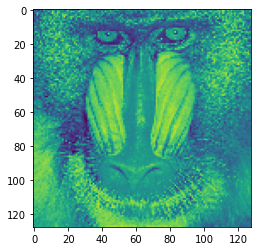

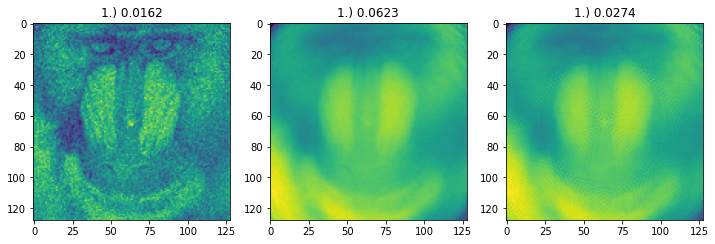

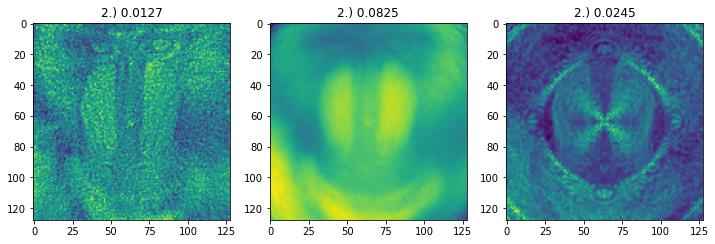

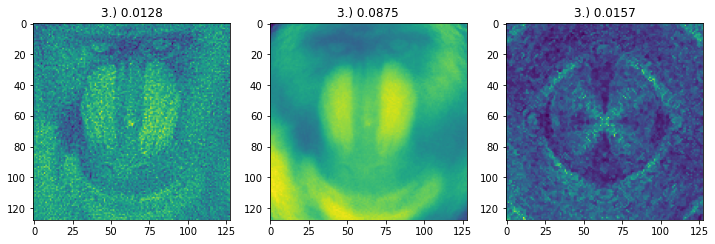

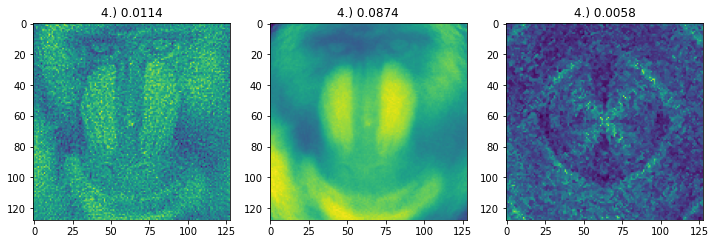

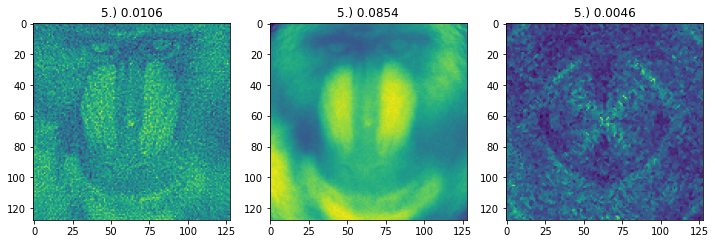

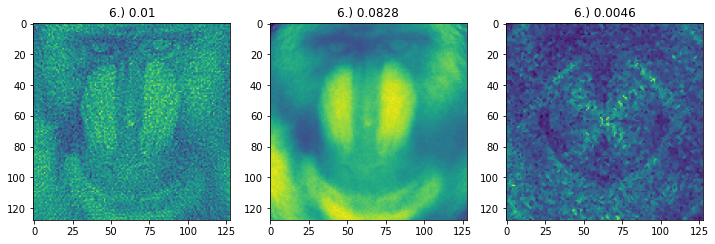

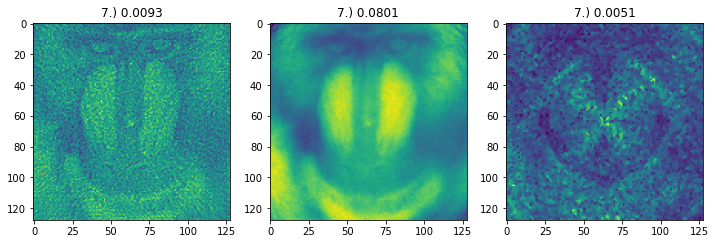

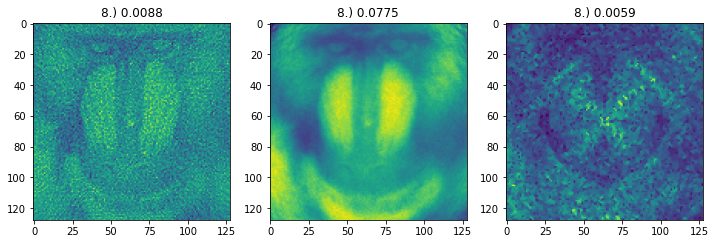

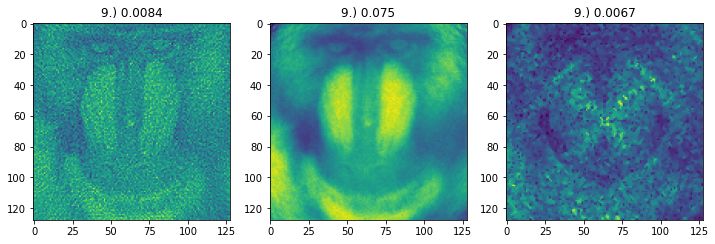

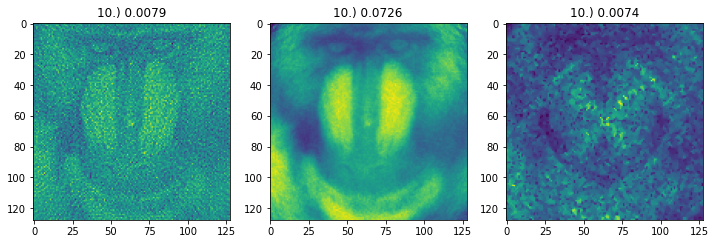

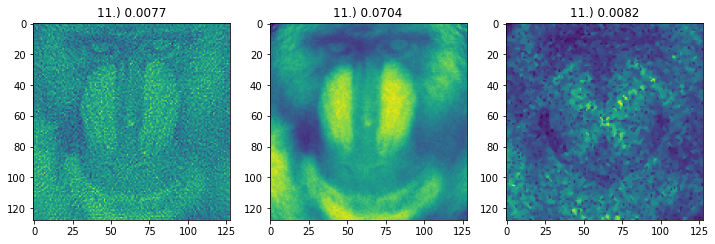

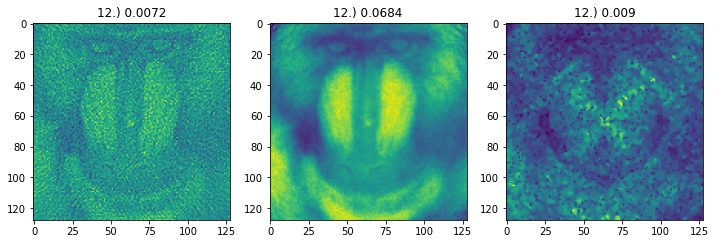

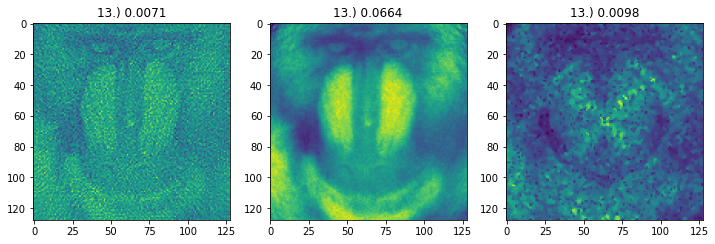

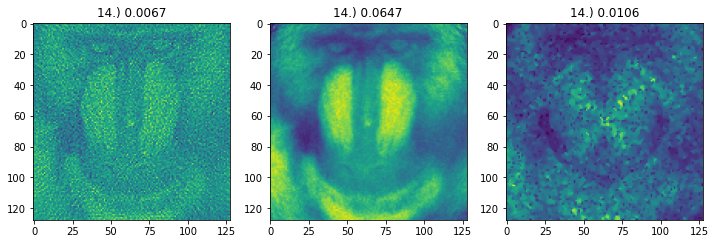

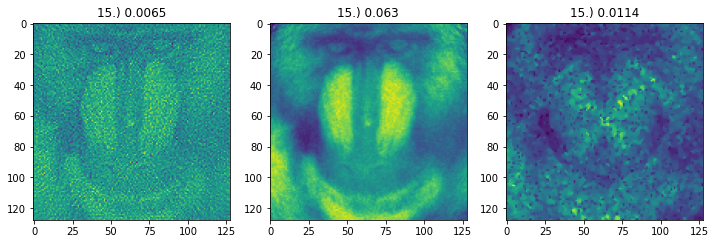

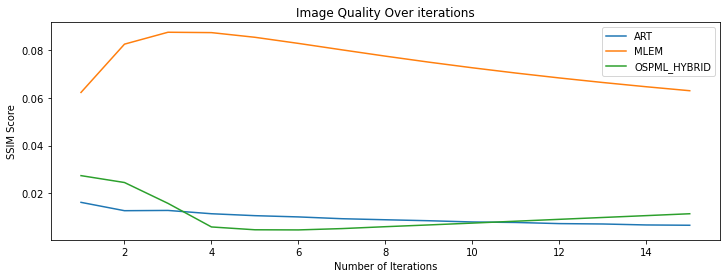

In [39]:
art_array = []
mlem_array = []
ospml_hybrid_array = []
print(obj.shape)
plt.figure()
plt.imshow(obj[0])
plt.show()
for x in range(0,45):
    if x%3==0:
        plt.figure(figsize=(12,4))
        plt.subplot(131+x%3)
        plt.imshow(rec['art']['iterations'][int(x/3)][0])
        str1 = str(round(int(x/3)+1,4))
        str1 += '.) '
        str1 += str(round(ssim(obj[0], rec['art']['iterations'][int(x/3)][0]),4))
        plt.title(str1)
        art_array.append(ssim(obj[0], rec['art']['iterations'][int(x/3)][0]))


    if x%3==1:
        plt.subplot(131+x%3)
        plt.imshow(rec['mlem']['iterations'][int(((x-x%3)/3))][0])
        str1 = str(round(int(((x-x%3)/3)+1),4))
        str1+= '.) '
        str1 += str(round(ssim(obj[0], rec['mlem']['iterations'][int(((x-x%3)/3))][0]),4))
        plt.title(str1)
        mlem_array.append(ssim(obj[0], rec['mlem']['iterations'][int(((x-x%3)/3))][0]))


    if x%3==2:
        plt.subplot(131+x%3)
        plt.imshow(rec['ospml_hybrid']['iterations'][int(((x-x%3)/3))][0])
        str1 = str(round(int((x-x%3)/3)+1,4))
        str1 += '.) '
        str1 += str(round(ssim(obj[0], rec['ospml_hybrid']['iterations'][int(((x-x%3)/3))][0]),4))
        plt.title(str1)
        ospml_hybrid_array.append(ssim(obj[0], rec['ospml_hybrid']['iterations'][int(((x-x%3)/3))][0]))


X=[]
for x in range(0,15):
    X.append(x+1)
    
plt.figure(figsize=(12,4))
plt.xlabel('Number of Iterations')
plt.ylabel('SSIM Score')
plt.title('Image Quality Over iterations')
plt.plot(X, art_array, label= 'ART')
plt.plot(X, mlem_array, label= 'MLEM')
plt.plot(X, ospml_hybrid_array, label= 'OSPML_HYBRID')
plt.legend()
plt.show()

From looking at the data, it is clear that the MLEM algorithm far outperforms the other two. It peaks at 3 iterations at an image quality of .0875 (on the SSIM index, the ideal is 1 with a range over (-1,1)). OSPML_HYBRID is the next best, with an intial high which quickly dips, and then slowly increases with more and more iterations. The ART algorithm is the worst, starting at a low quality and only decreaseing from there. 

Here we test to see what the effects of higher iterations over the OSPML_HYBRID will have.

In [47]:
rec['ospml_hybrid2']= dis('ospml_hybrid', 400, 16)

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstruc

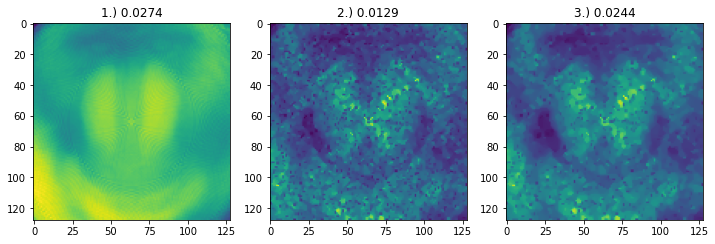

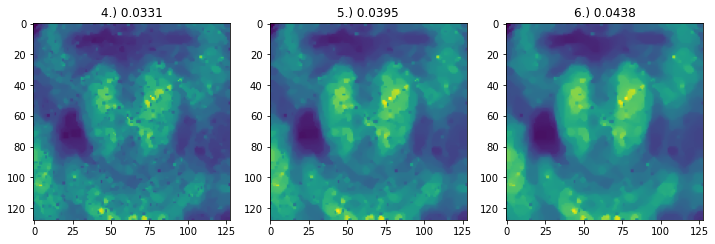

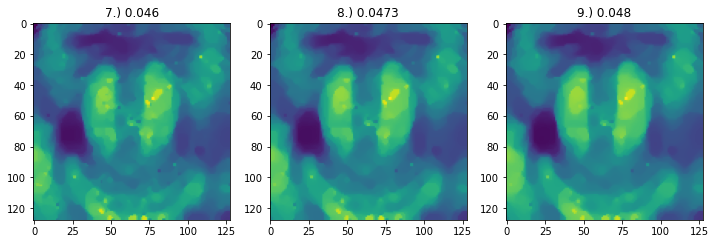

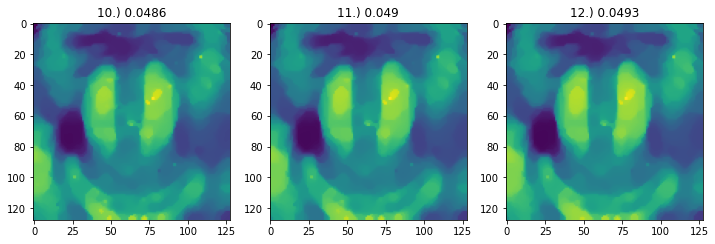

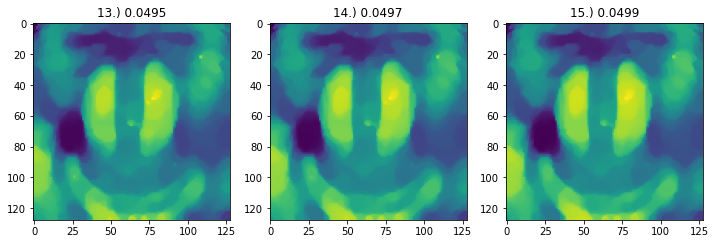

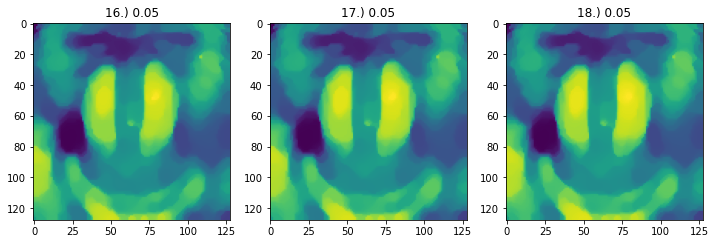

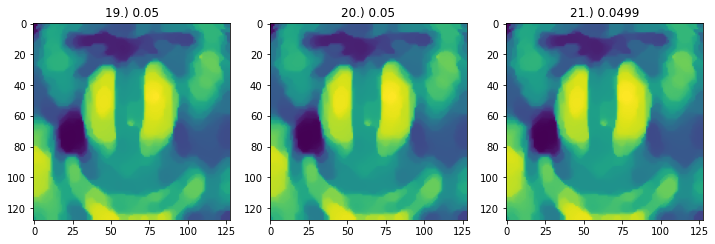

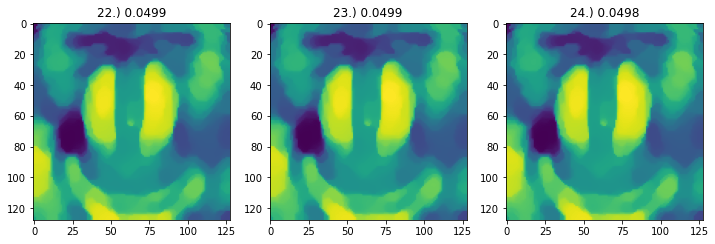

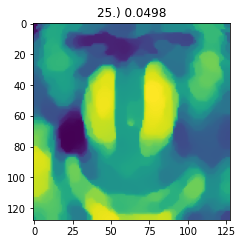

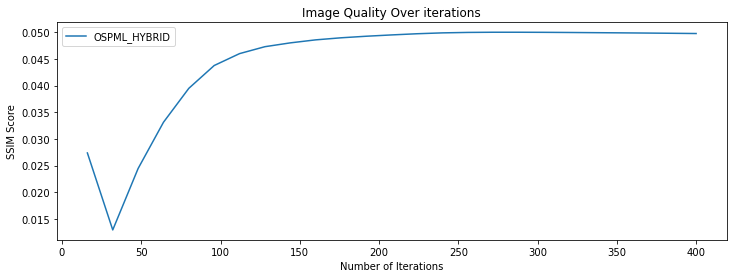

In [49]:
ospml_hybrid_array2=[]
for x in range(0,25):
    if x%3==0:
        plt.figure(figsize=(12,4))
    plt.subplot(131+x%3)
    plt.imshow(rec['ospml_hybrid2']['iterations'][x][0])
    str1 = str(x+1)
    str1 += '.) '
    str1 += str(round(ssim(obj[0], rec['ospml_hybrid2']['iterations'][x][0]),4))
    plt.title(str1)
    ospml_hybrid_array2.append(ssim(obj[0], rec['ospml_hybrid2']['iterations'][x][0]))


X=[]
for x in range(0,400,16):
    X.append(x+16)
    
plt.figure(figsize=(12,4))
plt.xlabel('Number of Iterations')
plt.ylabel('SSIM Score')
plt.title('Image Quality Over iterations')
plt.plot(X, ospml_hybrid_array2 , label= 'OSPML_HYBRID')
plt.legend()
plt.show()


As you can see, the OSPML_HYBRID seems to hit an max value of .05 and then slowly decreases. Althought the reconstructed images take on a plastic look which lacks many of the fine details, the error score remains somewhat high, which reflects the structrual importance that the SSIM metric uses. However, despite this improvment, the OSPML_HYBRID never tops the max of the MLEM method, and as the bottom graph shows, the method takes much longer as well.

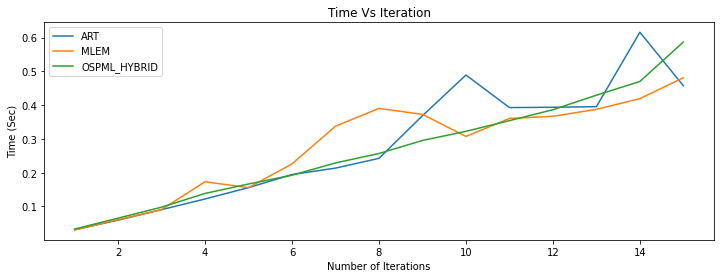

In [30]:
X = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]  
plt.figure(figsize=(12,4))
plt.xlabel('Number of Iterations')
plt.ylabel('Time (Sec)')
plt.title('Time Vs Iteration')
plt.plot(X, rec['art']['time'], label= 'ART')
plt.plot(X, rec['mlem']['time'], label = 'MLEM' )
plt.plot(X, rec['ospml_hybrid']['time'], label = 'OSPML_HYBRID')
plt.legend()
plt.show()

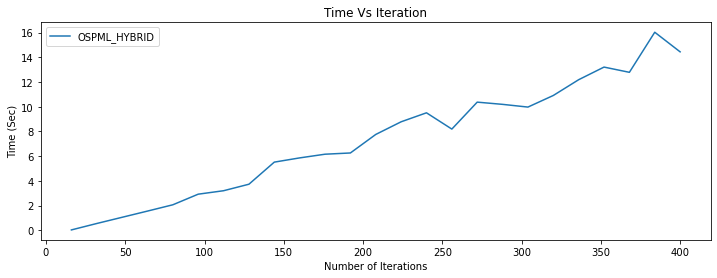

In [50]:
X=[]
for x in range(0,400,16):
    X.append(x+16)
    
plt.figure(figsize=(12,4))
plt.xlabel('Number of Iterations')
plt.ylabel('Time (Sec)')
plt.title('Time Vs Iteration')
plt.plot(X, rec['ospml_hybrid2']['time'], label = 'OSPML_HYBRID')
plt.legend()
plt.show()